# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

# Exoplanet data packages
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Dynamic nested sampling
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty import plotting as dyplot

# MCMC sampling
import emcee
import corner
from multiprocessing import Pool

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# Matplotlib settings
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

# Read in data

Period:  0.94145299 d +/-  8.7e-07 d
t_0:  2454221.48163 d +/-  0.00038 d
Transit duration:  2.14368 h


/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


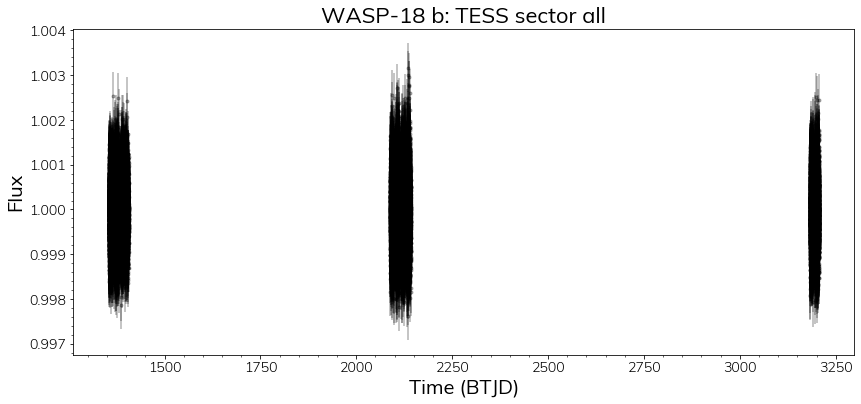

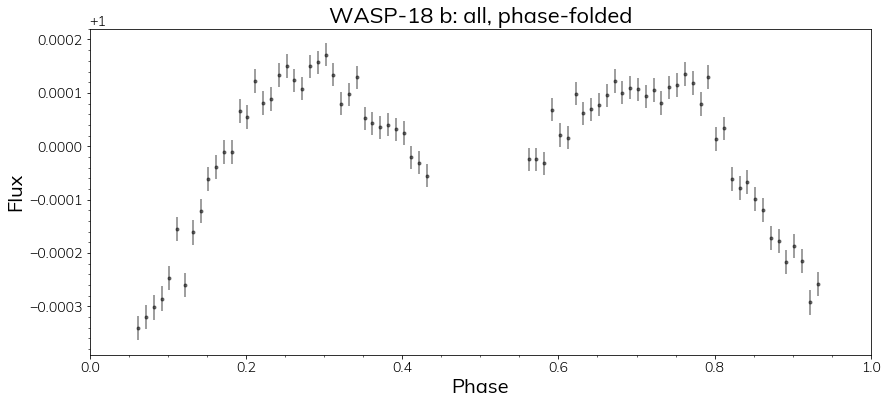

In [2]:
planet_name = 'WASP-18 b'
df = pd.read_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv', comment='#', header=0)
sectors = np.unique(df.sector)
sector_ind = 'all' # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_raw = np.array(df.flux_raw)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_raw = np.array(df.flux_raw)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        

# Store data as a Lightkurve object to make it easier for phase-folding
lc_data = {'time': time,
           'flux': flux,
           'flux_err': flux_err
          }
lc_data = lk.LightCurve(lc_data)

NEA_result = NasaExoplanetArchive.query_object(planet_name)
TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet
ephemeris_ind = 1 
# Extract orbital period (P), mid-transit time (t_0), and transit duration (t_dur)
P, t_0, t_dur = NEA_result['pl_orbper'][ephemeris_ind], NEA_result['pl_tranmid'][ephemeris_ind], \
NEA_result['pl_trandur'][ephemeris_ind].value*u.hour
P_err = (abs(NEA_result['pl_orbpererr1'][ephemeris_ind]) + abs(NEA_result['pl_orbpererr2'][ephemeris_ind]))/2.
t_0_err = (abs(NEA_result['pl_tranmiderr1'][ephemeris_ind]) + abs(NEA_result['pl_tranmiderr1'][ephemeris_ind]))/2.
print('Period: ', P, '+/- ', P_err)
print('t_0: ', t_0, '+/- ', t_0_err)
print('Transit duration: ', t_dur)
t_0 = t_0 - 2457000.0*u.day

bin_width = 0.01 * u.day
lc_data_fold = TPC.fold_lk(lc_data, P, t_0)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
mask = lc_data_bin.flux_err > np.nanmean(lc_data_bin.flux_err) + 3*np.nanstd(lc_data_bin.flux_err)
lc_data_bin = lc_data_bin[~mask]

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

# Plot phase-folded lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0, 1)
plt.title(planet_name+': '+sector+', phase-folded')
plt.show()

# Model-fitting

Set up Bayesian framework

In [3]:
# Names of all the model parameters
labels = [r'$t_0$', r'$P$', r'$f_p$', r'$\delta$',
          r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
ndim = len(labels) # number of model parameters

# Define an array of booleans that describe whether the priors will be uniform (True) or Gaussian (False) in order
priors_bool = np.array([True]*ndim)
priors_bool[0:2] = np.array([False]*2) # Setting the first two parameters to have Gaussian priors

# Define pairs of values that describe the priors for each parameter in order
priors = np.array([[t_0.value, 5*t_0_err.value], # t_0, Gaussian prior from Exoplanet Archive
                   [P.value, 5*P_err.value], # P, Gaussian prior from Exoplanet Archive
                   [-2e-3, 2e-3], # f_p, uniform prior
                   [-np.pi/4, np.pi/4], # delta, uniform prior
                   [-1e-2, 1e-2], # B_1, uniform prior
                   [-1e-3, 1e-3], # A_2, uniform prior
                   [-1e-3, 1e-3], # B_2, uniform prior
                   [-1e-3, 1e-3], # A_3, uniform prior
                   [-1e-3, 1e-3]]) # B_3, uniform prior

Define model, likelihood function arguments, and prior transform function arguments

In [4]:
### Likelihood function ###
def psi_tot_noPulse_noA1(params, t):
    t_0, P, fp, delta, B1, A2, B2, A3, B3 = params
    return TPC.psi_tot_no_pulse(t, t_0, P, fp, delta, 0, B1, A2, B2, A3, B3)

def psi_tot_noA1(params, t):
    t_0, P, PI, alpha, beta, fp, delta, B1, A2, B2, A3, B3 = params
    return TPC.psi_tot(t, t_0, P, PI, alpha, beta, fp, delta, 0, B1, A2, B2, A3, B3)

### Perform MCMC sampling with $\texttt{emcee}$

In [5]:
filename_root =''.join(planet_name.split())+'_sector'+str(sector)+'_v1' # filename at which to save progress
initial = [t_0.value, P.value, 0, 0, 0, 0, 0, 0, 0] # Initial parameter guess

nwalkers = 2*ndim + 1
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
backend = emcee.backends.HDFBackend(filename_root+'_sampling.save')
backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, TPC.logPosterior,
                                    args=(priors, priors_bool, lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, 
                                          psi_tot_noPulse_noA1),                                    
                                    pool=pool)
    max_n = 500000 # maximum number of iterations to run for

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break # break out of loop if convergence criteria are met
        old_tau = tau

# Plot distributions and fit
np.set_printoptions(suppress=True)
lnprob = sampler.get_log_prob()
lnprob_flat = sampler.get_log_prob(flat=True)
chain = sampler.get_chain()
params_best = np.percentile(res, 50, axis=0)
print('Best: ', params_best)

  5%|▍         | 24400/500000 [23:40<7:41:31, 17.17it/s] 

Best:  [-2778.51837056     0.94145299    -0.00004472     0.0214371
    -0.00015669    -0.00000038    -0.00013414    -0.00001488
    -0.00001293]


Plot corner plot of posterior distribution

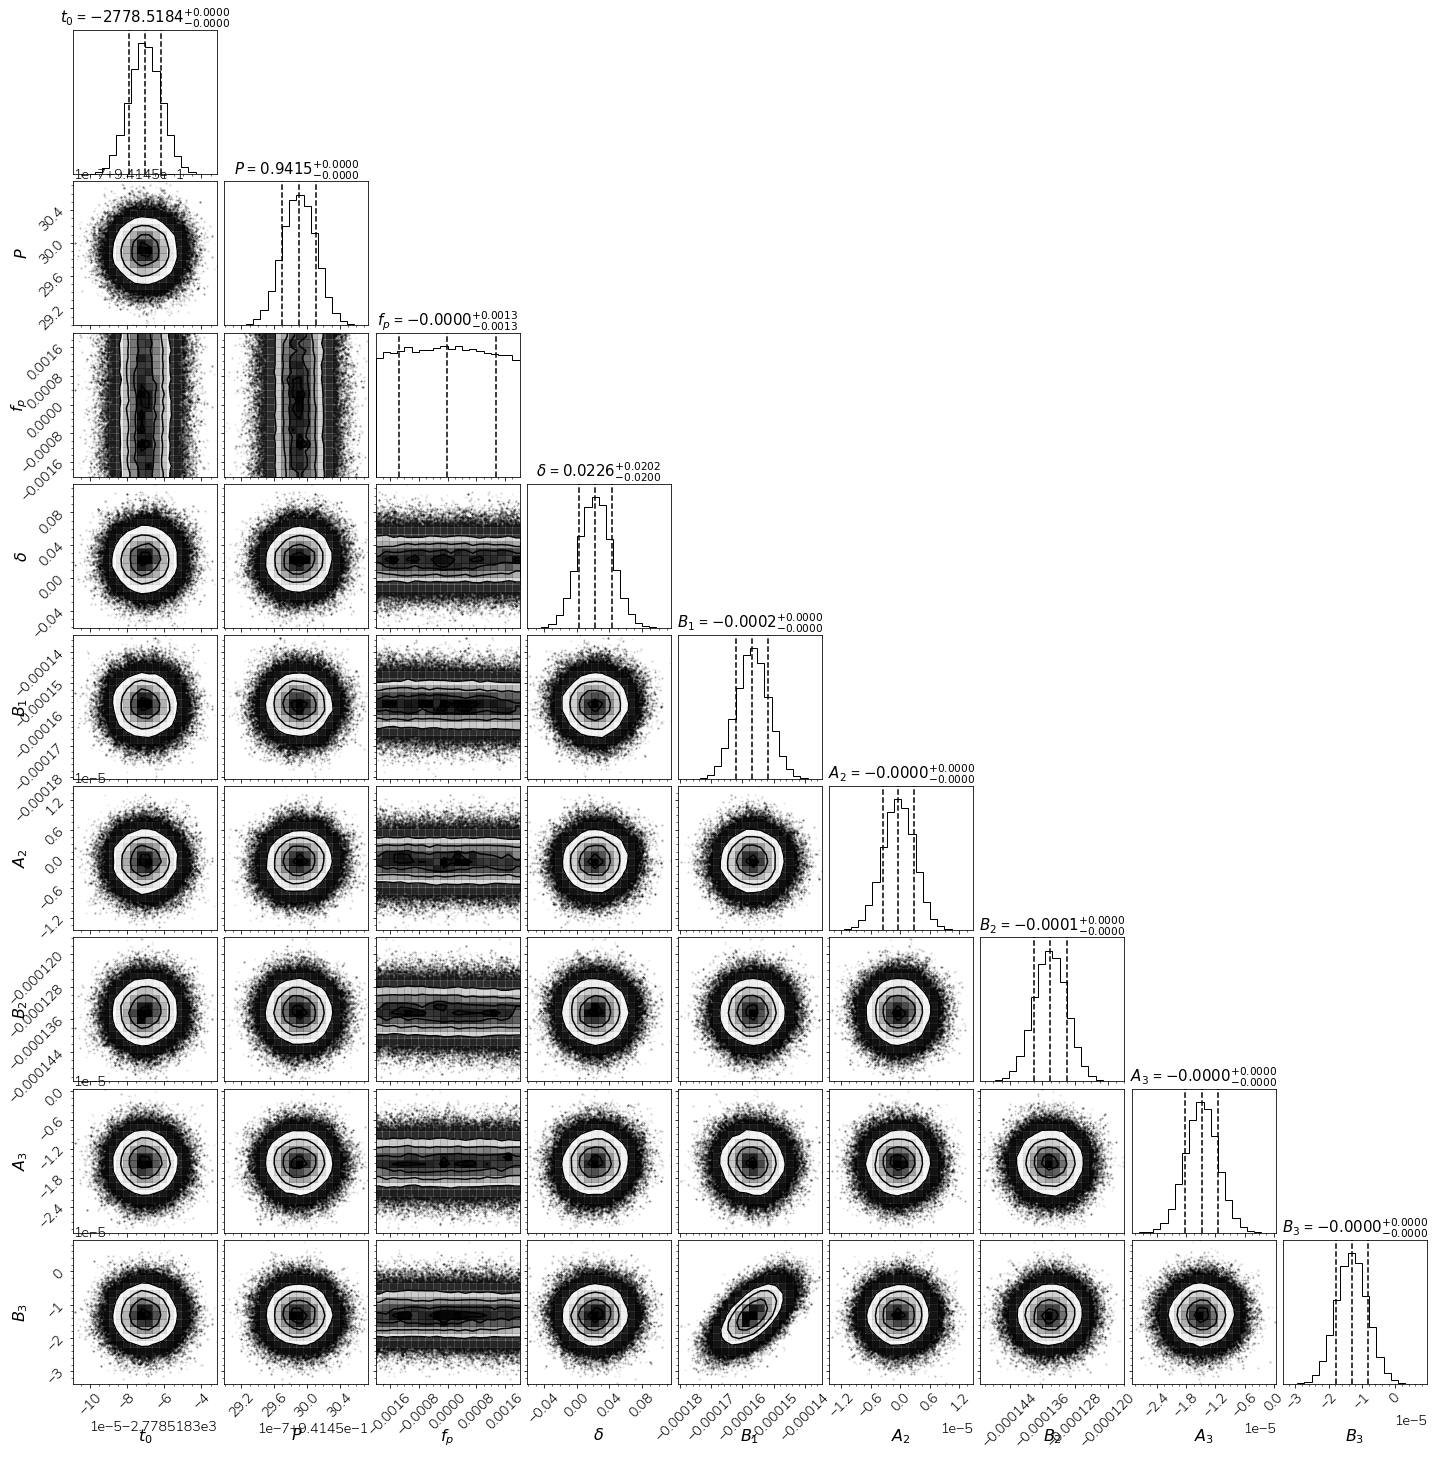

In [8]:
res = sampler.get_chain(flat=True, discard=1000)
fig = corner.corner(res, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        title_kwargs={"fontsize": 15},
                        title_fmt='.4f', label_kwargs={"fontsize": 16})
plt.show()

Plot best-fit model overlayed on data

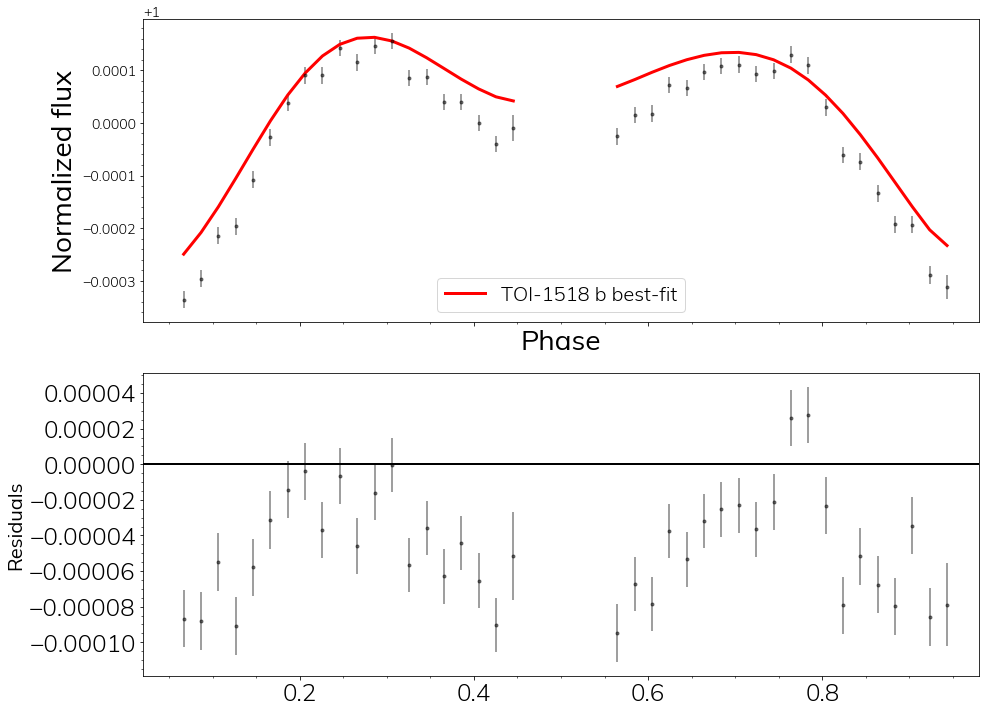

In [9]:
# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

### Compute the model light curve ###
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Calculate model and assign to a Lightkurve object
model = psi_tot_noPulse_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='r', linewidth=3, label='TOI-1518 b best-fit')
ax1.set_ylabel('Normalized flux', fontsize=28)

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
ax2.axhline(0, color='k', zorder=0, linewidth=2)
ax1.set_xlabel('Phase', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
ax2.set_ylabel('Residuals')
ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.show()

### Perform nested sampling with $\texttt{dynesty}$

In [9]:
loglike_args = (lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value,
                psi_tot_noPulse_noA1) # loglike function arguments
ptform_args = (priors, priors_bool) # prior_transform function arguments

# Initialize the sampler that will search the parameter space
sampler = DynamicNestedSampler(TPC.loglike, TPC.prior_transform, ndim,
                        logl_args=loglike_args, ptform_args=ptform_args)

# Run the sampler; we define convergence when the estimated contribution of the remaining prior volume to the
# total evidence falls below 1%
filename_root =''.join(planet_name.split())+'_sector'+str(sector)+'_v1' # filename at which to save progress
sampler.run_nested(dlogz_init=0.01, maxiter=100000, checkpoint_file=filename_root+'.save', print_progress=True)

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

10049it [2:04:10, 51.26s/it, batch: 0 | bound: 1223 | nc: 3587 | ncall: 934752 | eff(%):  1.074 | loglstar:   -inf < 321105.169 <    inf | logz: 321081.654 +/-  0.213 | dlogz: 140.072 >  0.010] /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  'The enlargement factor for the ellipsoidal bounds'
10542it [4:12:17, 32.00s/it, batch: 0 | bound: 2514 | nc: 5425 | ncall: 1903110 | eff(%):  0.554 | loglstar:   -inf < 321146.164 <    inf | logz: 321121.432 +/-  0.217 | dlogz: 99.326 >  0.010]  /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarnin

10768it [6:18:07, 91.99s/it, batch: 0 | bound: 3778 | nc: 14966 | ncall: 2851160 | eff(%):  0.378 | loglstar:   -inf < 321159.848 <    inf | logz: 321134.852 +/-  0.218 | dlogz: 85.429 >  0.010] /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  'The enlargement factor for the ellipsoidal bounds'
10813it [6:38:57, 22.06s/it, batch: 0 | bound: 3991 | nc: 83 | ncall: 3011391 | eff(%):  0.359 | loglstar:   -inf < 321163.125 <    inf | logz: 321138.030 +/-  0.220 | dlogz: 82.174 >  0.010]    /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarni

12569it [21:09:24,  3.99s/it, batch: 0 | bound: 12961 | nc: 24 | ncall: 9738793 | eff(%):  0.129 | loglstar:   -inf < 321225.918 <    inf | logz: 321198.345 +/-  0.230 | dlogz: 26.916 >  0.010]    /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  'The enlargement factor for the ellipsoidal bounds'
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This ma

12835it [21:54:28,  8.04s/it, batch: 0 | bound: 13426 | nc: 1234 | ncall: 10087356 | eff(%):  0.127 | loglstar:   -inf < 321230.952 <    inf | logz: 321203.280 +/-  0.231 | dlogz: 21.441 >  0.010]/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  'The enlargement factor for the ellipsoidal bounds'
/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may

12875it [22:51:13, 37.32s/it, batch: 0 | bound: 14016 | nc: 394 | ncall: 10529636 | eff(%):  0.122 | loglstar:   -inf < 321231.614 <    inf | logz: 321203.888 +/-  0.231 | dlogz: 20.753 >  0.010]   /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  'The enlargement factor for the ellipsoidal bounds'
12882it [22:58:41, 26.38s/it, batch: 0 | bound: 14093 | nc: 1071 | ncall: 10587559 | eff(%):  0.122 | loglstar:   -inf < 321231.713 <    inf | logz: 321203.991 +/-  0.231 | dlogz: 20.636 >  0.010]  /home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/bounding.py:619: Use

Traceback (most recent call last):
  File "/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/home/paiasnodkar.1/TESSPhaseCurves/TESSPhaseCurve_lib.py", line 342, in loglike
    model = model_func(theta, x)
  File "<ipython-input-8-eabbc3d5a343>", line 4, in psi_tot_noPulse_noA1
    return TPC.psi_tot_no_pulse(t, t_0, P, fp, delta, 0, B1, A2, B2, A3, B3)
  File "/home/paiasnodkar.1/TESSPhaseCurves/TESSPhaseCurve_lib.py", line 49, in <lambda>
    (psi_p(t, t_0, P, fp, B1, delta) + psi_star_sum(t, t_0, P, A1, A2, B2, A3, B3))/(1. + fp)
  File "/home/paiasnodkar.1/TESSPhaseCurves/TESSPhaseCurve_lib.py", line 36, in <lambda>
    psi_star_3(t, t_0, P, A3, B3)
  File "/home/paiasnodkar.1/TESSPhaseCurves/TESSPhaseCurve_lib.py", line 33, in <lambda>
    psi_star_3 = lambda t, t_0, P, A3, B3: A3*np.sin(2*np.pi*3*phi(t, t_0, P)) + B3*np.cos(2*np.pi*3*phi(t, t_0, P))
  

Exception while calling loglikelihood function:
  params: [-2.77852253e+03  9.41449072e-01 -7.61495672e-04  3.03886401e+00
 -3.74614540e-04 -6.63345730e-05 -7.60851084e-05 -6.75177565e-05
 -2.39736440e-05]
  args: (array([1354.51429692, 1354.51568585, 1354.51707478, ..., 3206.13328248,
       3206.13467136, 3206.13606025]), array([0.99896474, 0.99934998, 0.9991306 , ..., 1.00139084, 1.00077228,
       1.00019529]), array([0.00054265, 0.00054286, 0.00054284, ..., 0.0005804 , 0.0005803 ,
       0.00058044]), <function psi_tot_noPulse_noA1 at 0x7fa110c5b7a0>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

Plot corner plot of posterior distribution

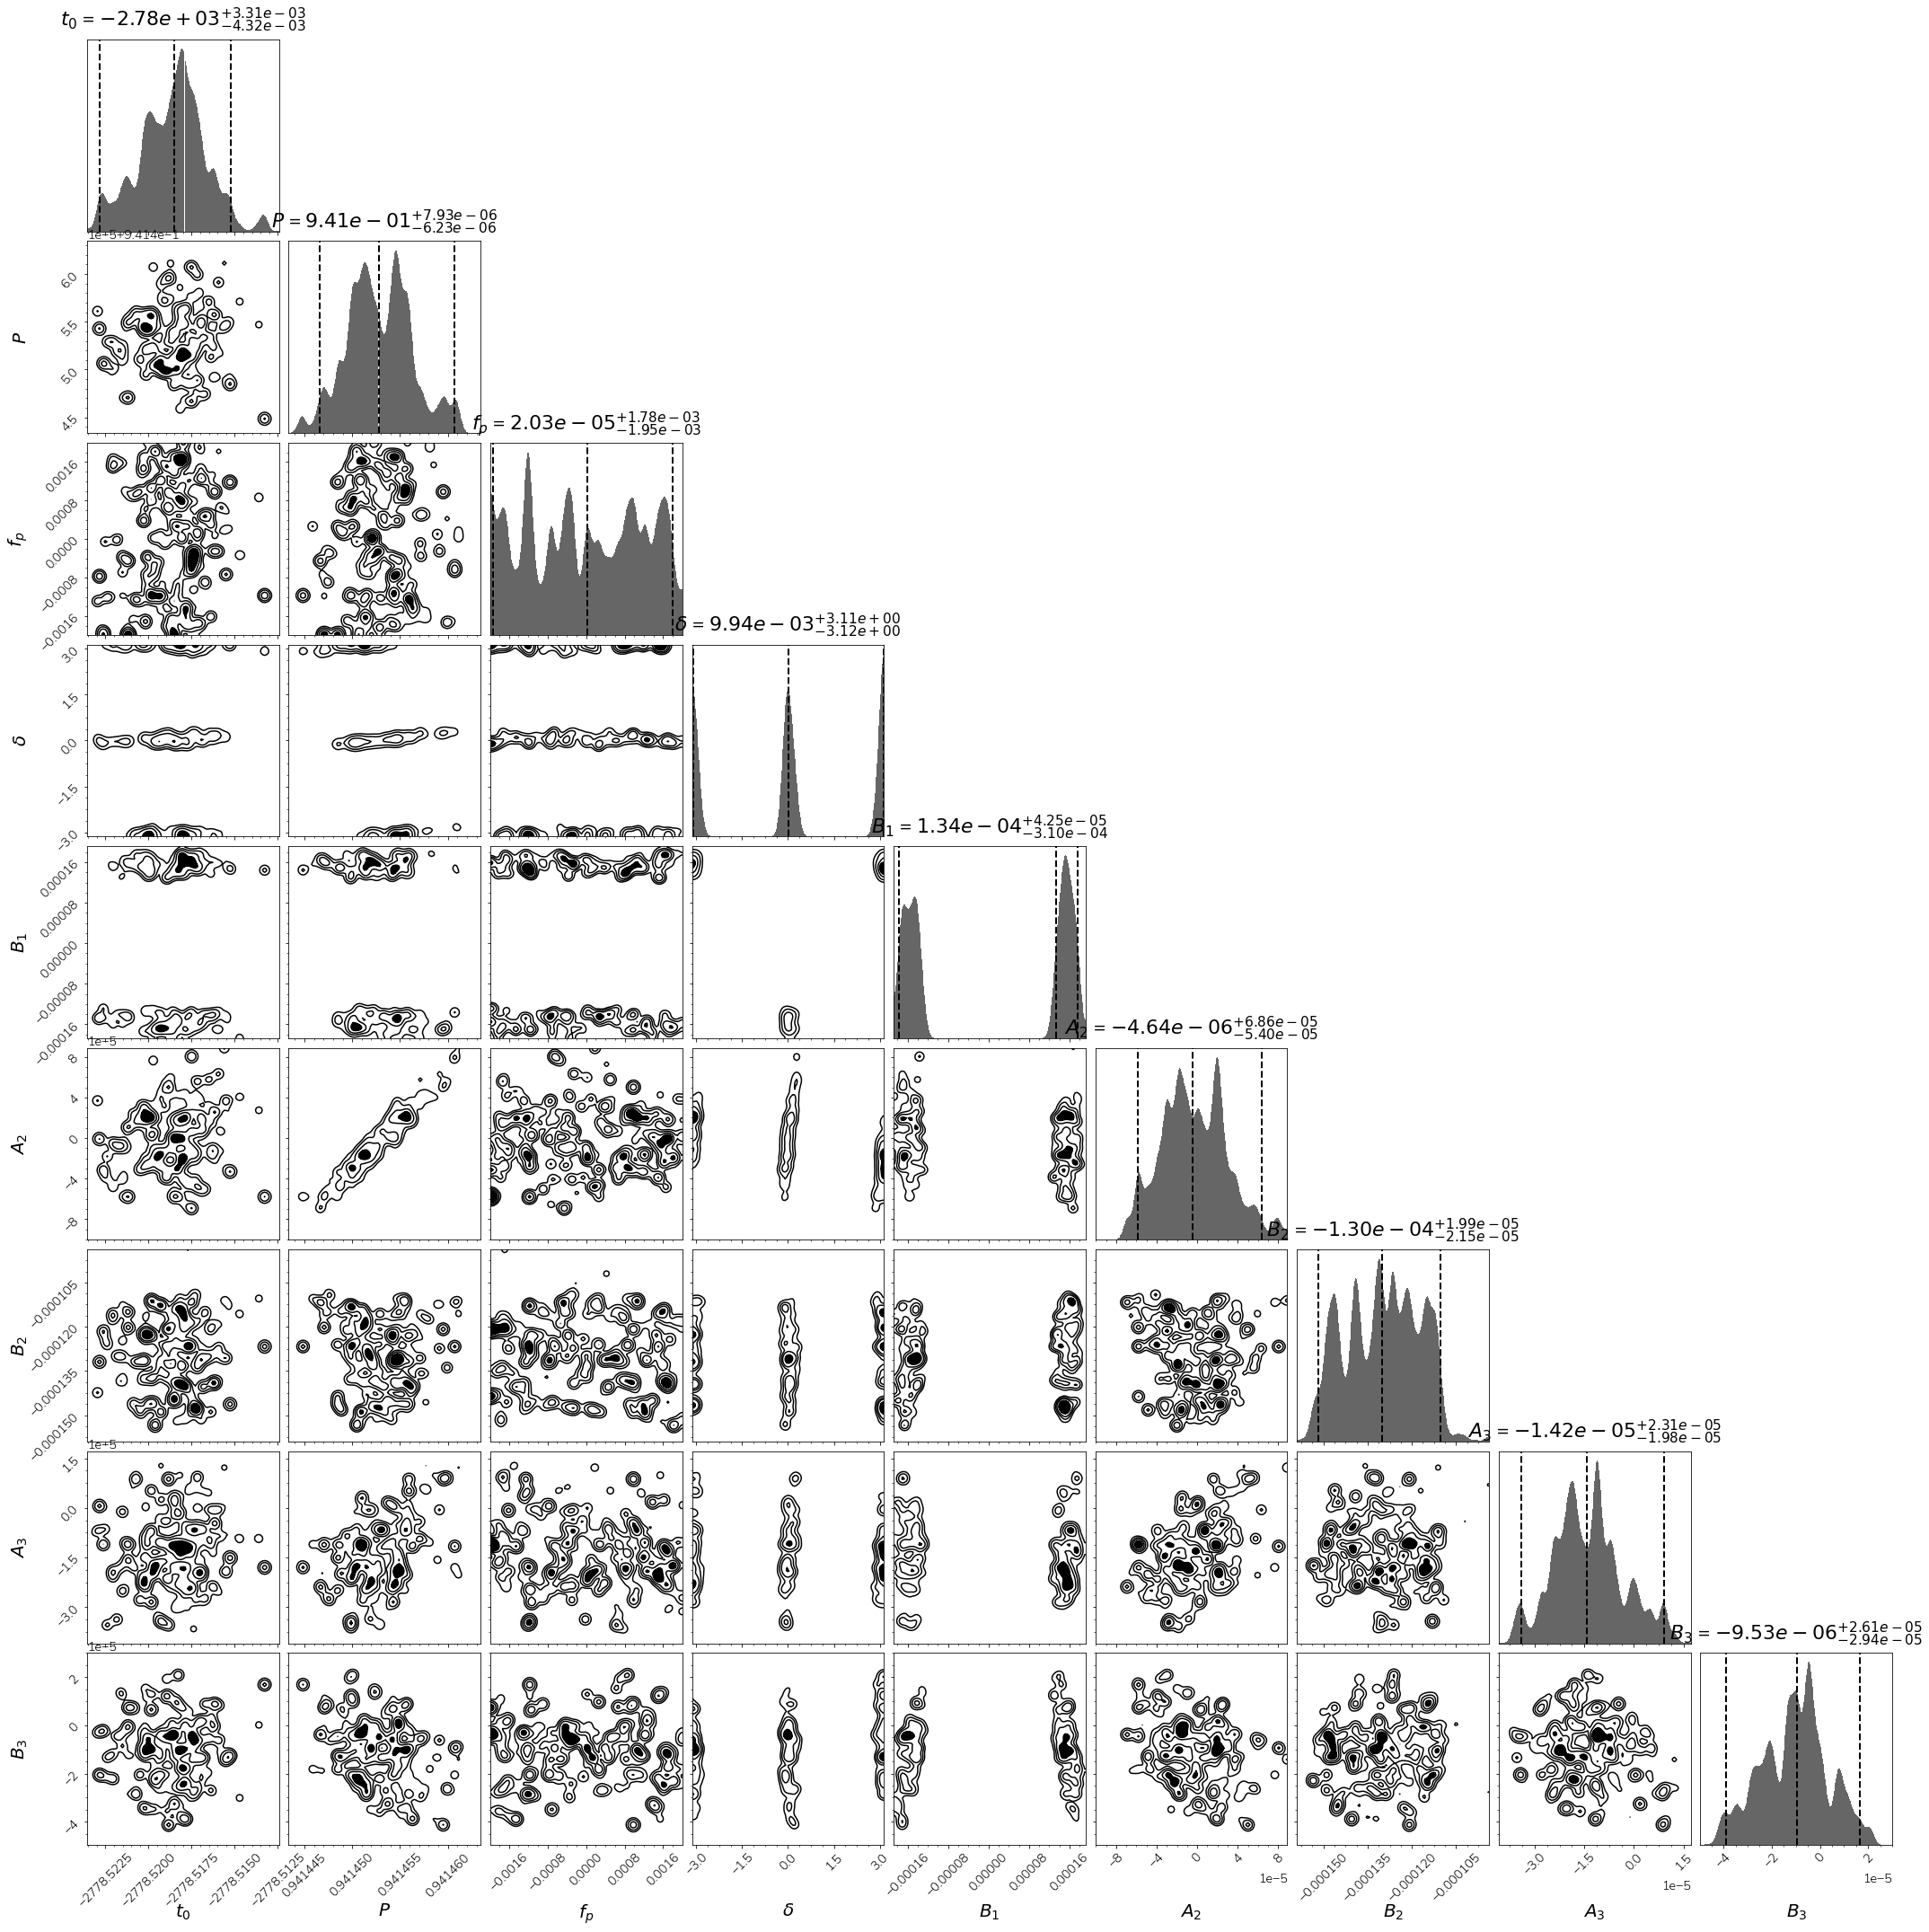

In [10]:
# Restore sampler
sampler = NestedSampler.restore(''.join(planet_name.split())+'_sector'+str(sector)+'_v1.save')

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

### Corner plot ###

truths = (P.value, t_0.value, None, None, None, None, None, None, None, None)
# labels = [r'$t_0$', r'$P$',  r'$\Pi$', r'$\alpha$', r'$\beta$', r'$f_p$', r'$\delta$',
#           r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
labels = [r'$t_0$', r'$P$',  r'$f_p$', r'$\delta$',
          r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']

fig, axes = dyplot.cornerplot(res, show_titles=True, title_fmt='0.2e',
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(ndim, ndim, figsize=(30, 30)))

Plot best-fit model overlayed on data

In [ ]:
### Compute the model light curve ###
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = psi_tot_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model.time.value, lc_model.flux.value, color='r', linewidth=3, label='TOI-1518 b best-fit')
ax1.set_ylabel('Normalized flux', fontsize=28)
ax1.set_xlim(2750, 2800)

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
# residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
# ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
# ax2.axhline(0, color='k', zorder=0, linewidth=2)
# ax1.set_xlabel('Phase', fontsize=28)
# plt.xticks(fontsize=24)
# plt.yticks(fontsize=24)
# ax2.set_ylabel('Residuals')
# ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.show()

Example of model fitting

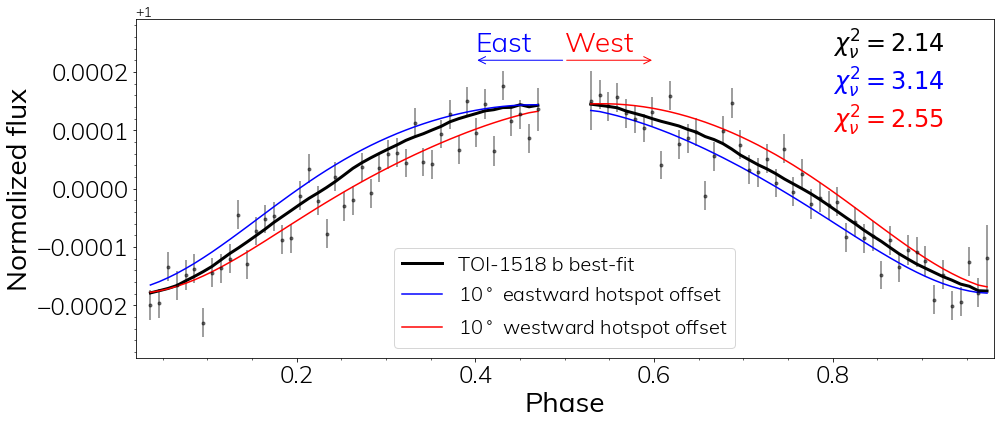

[ 1.78704927e+03  1.90260901e+00  1.22910302e+00  2.66298455e-05
  6.43091804e-06  1.23615437e-03 -7.99870435e-04 -1.58846842e-04
  1.18295167e-06 -1.86883806e-05 -5.08533487e-07 -3.71328072e-06]


In [67]:
### Compute the model light curve ###

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = psi_tot_noA1(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)

params_east = np.hstack([params_best[0:2], params_best[5:]])
params_east[3] = 10 * np.pi/180
east = psi_tot_noPulse_noA1(params_east, lc_data.time.value)
lc_east = {'time': lc_data.time.value,
           'flux': east,
          }
lc_east = lk.LightCurve(lc_east)

params_west = np.hstack([params_best[0:2], params_best[5:]])
params_west[3] = -10 * np.pi/180
west = psi_tot_noPulse_noA1(params_west, lc_data.time.value)
lc_west = {'time': lc_data.time.value,
           'flux': west,
          }
lc_west = lk.LightCurve(lc_west)

# Phase fold and bin data and model
# bin_width = (9*u.min).to(u.day)/P_best * u.day
bin_width = (27*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_east_fold = TPC.fold_lk(lc_east, P_best, t_0_best)
lc_east_bin = lc_east_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_west_fold = TPC.fold_lk(lc_west, P_best, t_0_best)
lc_west_bin = lc_west_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

chisq_model = np.nansum(((lc_data_bin.flux - lc_model_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)
chisq_east = np.nansum(((lc_data_bin.flux - lc_east_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)
chisq_west = np.nansum(((lc_data_bin.flux - lc_west_bin.flux)**2)/(lc_data_bin.flux_err**2))/(len(lc_data_bin)-ndim)

chisq_text_model = r'$\chi^2_\nu = '+str(round(chisq_model.value, 2))+'$'
chisq_text_east = r'$\chi^2_\nu = '+str(round(chisq_east.value, 2))+'$'
chisq_text_west = r'$\chi^2_\nu = '+str(round(chisq_west.value, 2))+'$'

# Initialize figure
fig, ax1 = plt.subplots(1, sharex=True, figsize=(14, 6))#, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
# ax1.scatter(lc_data_fold.time.value, lc_data_fold.flux.value, marker='.', color='k', alpha=0.05)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='k', linewidth=3, label='TOI-1518 b best-fit')
ax1.plot(lc_east_bin.time.value, lc_east_bin.flux.value, color='blue', label=r'10$^\circ$ eastward hotspot offset')
ax1.plot(lc_west_bin.time.value, lc_west_bin.flux.value, color='red', label=r'10$^\circ$ westward hotspot offset')
ax1.set_ylabel('Normalized flux', fontsize=28)
ax1.set_xlim(0.02, 0.98)
ax1.set_ylim(1-0.00029, 1+0.00029)


ax1.annotate('', xy=(0.5, 1.00022), xytext=(0.4, 1.00022),
            fontsize=18, color='blue', arrowprops=dict(arrowstyle="<-", color='blue'))
ax1.annotate('', xy=(0.5, 1.00022), xytext=(0.6, 1.00022),
            fontsize=18, color='red', arrowprops=dict(arrowstyle="<-", color='red'))
ax1.text(0.4, 1.000235, 'East', color='blue', fontsize=28)
ax1.text(0.5, 1.000235, 'West', color='red', fontsize=28)

ax1.text(0.8, 1.000235, chisq_text_model, color='k', fontsize=24)
ax1.text(0.8, 1.00017, chisq_text_east, color='blue', fontsize=24)
ax1.text(0.8, 1.000105, chisq_text_west, color='red', fontsize=24)
# ax1.text(0.5-10./360, 1.0003, 'East', fontsize=18)


# # Plot residuals
# residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
# residuals_fold = lc_data_fold.flux.value - lc_model_fold.flux.value
# ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
# # ax2.scatter(lc_data_fold.time.value, residuals_fold, marker='.', color='k', alpha=0.05)
# ax2.axhline(0, color='k', zorder=0, linewidth=2)
ax1.set_xlabel('Phase', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# ax2.set_ylabel('Residuals')
# ax2.set_xlim(0.02, 0.98)

# Formatting
plt.tight_layout()
ax1.legend(fontsize=20)
plt.savefig('../TOI-1518b.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print(params_best)